# K-fold + LGBM importance + Permutation importance + Boruta SHAP

In [ ]:
import math

import numpy as np
import pandas as pd

import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, BaseShuffleSplit, _validate_shuffle_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import log_loss

from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target

import eli5
from IPython.display import display
from eli5.permutation_importance import get_score_importances
from eli5.sklearn import PermutationImportance

from shaphypetune import BoostBoruta

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from colorama import Style, Fore

palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

class CFG:
    n_repeats = 4
    n_folds = 5

params = {
        'boosting_type':'goss',
        'learning_rate': 0.06733232950390658, 
        'n_estimators': 50000, 
        'early_stopping_round' : 100, 
        'subsample' : 0.6970532011679706,
        'colsample_bytree': 0.6055755840633003,
        'num_leaves': 6,
        # 'class_weight': 'balanced',
        # 'is_unbalance': True, 
        'metric': 'none', 
        'random_state': 8062023,
        'feature_fraction_seed': 8062023,
        'bagging_seed': 8062023,
        'max_depth': 8,
        'reg_alpha': 0.08866046540248787,  
        'reg_lambda': 1.0245261859148395e-06,
        'importance_type': 'gain'
        }

def lgbm_tuning(df, permut=False, boruta=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern']]
    groups = df['ticker']

    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    boruta_df_ = pd.DataFrame()
    
    for i in range(CFG.n_repeats):
        print(f'Repeat {blu}#{i+1}')
        
        if task_type == 'cls':
            y_fold = df['target'] >= df['close']
            kf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=180820231)
            eval_metric = 'logloss'
        else:
            y_fold = (df['target'] - df['close']) / df['close']
            kf = GroupKFold(n_splits=CFG.n_folds)
            eval_metric = 'mse'

        X, y = df[features], y_fold
        oof = np.zeros(len(df))
        models_ = [] # Used to store models trained in the inner loop.
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y, groups)):
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            if task_type == 'cls':
                clf = lgb.LGBMClassifier(**params)
            else:
                clf = lgb.LGBMRegressor(**params)
            clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            models_.append(clf)

            if task_type == 'cls':
                val_preds = clf.predict_proba(X_val)[:,1]
                val_score = log_loss(y_val, val_preds)
            else:
                val_preds = clf.predict(X_val)
                val_score = mean_squared_error(y_val, val_preds, squared=False)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
                    
            # BORUTA importance
            if boruta:
                model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
                try:
                    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                            eval_metric=eval_metric, 
                            callbacks=[lgb.log_evaluation(100)])
                except RuntimeError:
                    continue
                
                boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, 
                                                        index=X_train.columns).sort_index()
                if boruta_df_.shape[0] == 0:
                    boruta_df_ = boruta_importance_df.copy()
                else:
                    boruta_df_ += boruta_importance_df

        if task_type == 'cls':
            outer_cv = log_loss(y, oof)
        else:
            outer_cv = mean_squared_error(y, oof, squared=False)
        
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
        
    if boruta:
        boruta_df_ = boruta_df_.sort_values('importance')
        boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, boruta_df_, np.mean(outer_cv_score)

task_type = 'reg'
perm_df_, feature_importances_, boruta_df_, outer_cv_score = lgbm_tuning(train_df, permut=True, boruta=True)

# perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
# boruta_df_['rank'] = boruta_df_['importance'].rank()
# feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

# res = pd.concat([perm_df_[['Feature','rank']], boruta_df_[['Feature','rank']], feature_importances_[['Feature','rank']]])
# res.groupby('Feature')['rank'].sum().sort_values().head(30).index.to_list()

# SelectKBest Method from SKLearn for Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

threshold = 0.1
t_score = 5

# Initiate the SelectKBest function
# For regression tasks: f_regression, mutual_info_regression
# For classification tasks: chi2, f_classif, mutual_info_classif
fs = SelectKBest(score_func=f_classif, k=len(train.columns))

# apply feature selection
X_selected = fs.fit_transform(train, test.values)
print('Befoe the SelectKBest = {}'.format(train.shape))

new_features = [] # The list of features less than the p-values
drop_features = [] # The list of features higher than the p-values

for i in range(len(train.columns)):
    print('Feature {}: {:.3f} with p-value {:.3f}'.format(train.columns[i], fs.scores_[i], fs.pvalues_[i]))
    if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
#    print(X_selected_final.shape)
X_selected_final = X_selected_final[new_features]
#    print(X_selected_final.shape)

print('=' * 30)
print('After the SelectKBest = {}'.format(X_selected_final.shape))
print('Drop-out Features = {}'.format(len(drop_features)))

# Select features using Information Value (IV) and Weights of evidence (WoE)

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

a,b = iv_woe(train2, target_name, bins=10, show_woe=False)

# most important features based on IV
a.sort_values(by='IV',ascending=False).Variable.values 

# deleting all IVs below 0.05
a = a.loc[a['IV']> 0.05]

# Select features with low correlation

In [ ]:
threshold = 0.3

cc = df[features[2:]].corr()

mat_x = abs(cc) > threshold
mat_x = mat_x.to_numpy()

names = list(cc)
low_corr_features = list()
low_corr_features.append(names[0])
max_features = 100
count = 1

for n in range(1, len(names)):
    if (mat_x[n,:n+1].sum()) == 1:
        low_corr_features.append(names[n])        
        count += 1
        if(count == max_features):
            break

# Select features with featurewiz

In [ ]:
from featurewiz import featurewiz
out, _ = featurewiz(df, 'Class', corr_limit=0.5, verbose=2)

data_sel = df[out]
data_sel['Class'] = df.Class

# Sort features according to their std, skewness and kurtosis

May be usefull for finding some interesting features

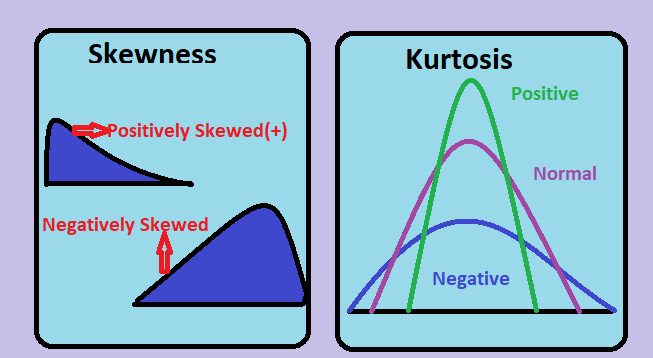

In [ ]:
num_cols = ['Age', 'Income']

features_std = df.loc[:, num_cols].apply(lambda x: np.std(x)).sort_values(ascending=False)
f_std = df[features_std.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True): # mode.use_inf_as_na means treat infinities as NaN
    features_skew = np.abs(df.loc[:,num_cols].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = df[features_skew.iloc[:20].index.tolist()]

with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(df.loc[:,num_cols].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = df[features_kurt.iloc[:20].index.tolist()]